# Intro

### About the data
- The Current Population Survey (CPS) is a monthly survey of about 60,000 U.S. households conducted by the United States Census Bureau that began in 1940 to measure unemployment. (This was started in the wake of the Great Depression).
- Since 1948, the March CPS suveys have included supplementary questions on income, used for statistics on income, poverty, and health insurance coverage. This is the Annual Social and Economic Supplement (ASEC).
- The CPS and ASEC data is annoying for a number of reasons:
    - The questions, coding, and format of the surveys are inconsistent from year to year
    - The official interfaces for retrieving the data are really difficult and annoying. You have to download one year at a time of a giant zip folder containing 3 enormous excel files with ~100 pages of documentation you need to decode. (Which is partially why it took a long time to source the data.)
- So: the Minnesota Population Center created IPUMS, where they've tried to make the survey data as consistent as possible betwen years, and create a much easier-to-use interface.

See also:
- [Wikipedia on CPS and ASEC](https://en.wikipedia.org/wiki/Current_Population_Survey)
- [IPUMS about page](https://cps.ipums.org/cps/about.shtml)

### Data preparation issues

This data is tricksy. Here are some of the issues that need to be navigated:
- Figuring out what exactly the variables represent
- Inflation, which requires CPI-based adjustments
- Some incomes are replaced with codes, such as "999999999" meaning "this individual is under 15 and outside the scope of the survey." Different variables have different codes.
- Making sure households aren't double-counted from multiple individuals in the same household
- High income values are obfuscated for privacy, but this has been done differently in different years. In early surveys incomes were simply truncated above some value, but since the 90s there's been replacement values, and rank proximity swapping and I haven't spent much time figuring out how that works.
- Samples need to be weighted because some households are more likely to be surveyed than others
- There is both cross-sectional data and longitudinal data
- There are inconsistencies in how surveys were conducted over the years. See [here](https://cps.ipums.org/cps/asec_sample_notes.shtml).

### How to obtain the data
1. Register on [IPUMS](https://cps.ipums.org/cps/)
2. Click `GET DATA`
3. Select the VARIABLES:
    - Household > Core > Economic Characteristics > HHINCOME (ie, Household income)
    - Person > Core > Demographics > SEX
    - Person > ASEC > Income > INCTOT (ie, Total personal income)
    - Person > ASEC > Income > FTOTVAL (ie, Family family income)
4. Select the SAMPLES:
    - You want to select “cross-sectional” rather than “longitudinal” because:
        - Longitudinal has data for both the beginning and the end of a 12-month period for each person surveyed. This is extraneous for our purposes and only confuses matters. 
        - Cross-sectional data also goes back further (1962 vs 1978).
     - Select all years from 1962 up to the present.
5. I recommend setting the DATA FORMAT to .csv.
    - By default it’s set to .dat which you need R or other unusual software to extract.
6. Press “CREATE DATA EXTRACT”
7. Wait for the data extract to be created (takes less than a minute) and download it.

# Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image

plt.style.use('ggplot')

data = pd.read_csv('data/cps_00002.csv')

In [2]:
data

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,HFLAG,ASECWTH,HHINCOME,PERNUM,CPSIDP,CPSIDV,ASECWT,AGE,SEX,FTOTVAL,INCTOT
0,1962,1,3,NaN,NaN,NaN,1494.99,NaN,1,NaN,NaN,1494.99,18,2,NaN,0
1,1962,2,3,NaN,NaN,NaN,1568.53,NaN,1,NaN,NaN,1568.53,14,1,NaN,999999999
2,1962,3,3,NaN,NaN,NaN,6443.03,NaN,1,NaN,NaN,6443.03,72,1,NaN,999999999
3,1962,4,3,NaN,NaN,NaN,1473.97,NaN,1,NaN,NaN,1473.97,29,1,NaN,1692
4,1962,5,3,NaN,NaN,NaN,1538.21,NaN,1,NaN,NaN,1538.21,21,1,NaN,1522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9843809,2023,88977,3,0.0,1.0,NaN,413.20,90415.0,4,0.0,0.0,379.43,17,2,90415.0,0
9843810,2023,88977,3,0.0,1.0,NaN,413.20,90415.0,5,0.0,0.0,410.10,15,1,90415.0,0
9843811,2023,88978,3,0.0,1.0,NaN,416.37,118070.0,1,0.0,0.0,416.37,59,1,118070.0,33113
9843812,2023,88978,3,0.0,1.0,NaN,416.37,118070.0,2,0.0,0.0,416.37,60,2,118070.0,78092


### Codes

When data are missing, or individuals are NIU ("not in universe", meaning they're outside the population, eg, because they're under 15), the income is given as a code, which for our purposes we should replace with NaN.
- [HHINCOME codes](https://cps.ipums.org/cps-action/variables/HHINCOME#codes_section)
- [INCTOT codes](https://cps.ipums.org/cps-action/variables/INCTOT#codes_section)

In [3]:
data['HHINCOME'] = data['HHINCOME'].replace([99999999], np.nan)
data['INCTOT'] = data['INCTOT'].replace([999999999,999999998], np.nan)

### Check max/min values

To see if they're being truncated.

The relevant documenation should be [here](https://cps.ipums.org/cps/topcodes_tables.shtml#replacement_values), but it doesn't actually mention `INCTOT` or `HHINCOME` and I haven't absorbed how this works.

In [4]:
def get_income_stats(data, income_col, year_col):
    data_filtered = data[data[income_col].notna()]
    grouped_data = data_filtered.groupby(year_col)
    income_stats = {year: {'min_income': group[income_col].min(), 'max_income': group[income_col].max()}
                    for year, group in grouped_data}
    return pd.DataFrame(income_stats).T

In [5]:
get_income_stats(data, 'INCTOT', 'YEAR')

,min_income,max_income
1962,-9995.0,121900.0
1963,-9970.0,76000.0
1964,-11000.0,123900.0
1965,-9995.0,132500.0
1966,-19990.0,115400.0
...,...,...
2019,-13000.0,2055999.0
2020,-9999.0,2085704.0
2021,-15995.0,2950301.0
2022,-9999.0,2082782.0


Looks like some of these are being truncated at -9999?

In [6]:
get_income_stats(data, 'HHINCOME', 'YEAR')

,min_income,max_income
1968,-9999997.0,50000.0
1969,-9999997.0,50000.0
1970,-9999997.0,50000.0
1971,-9999997.0,50000.0
1972,-9999997.0,50000.0
1973,-9999997.0,50000.0
1974,-9999997.0,50000.0
1975,-9999997.0,50000.0
1976,-12856.0,200420.0
1977,-13817.0,155000.0


The 1968-1975 data is very weird. Oh well.

### Inflation adjustment

We will be using the variables `INCTOT` (individual income), and `HHTOT` (household income), which is derived from `INCTOT`. The [INCTOT variable description](https://cps.ipums.org/cps-action/variables/INCTOT#description_section) states: 
> users must adjust for inflation using Consumer Price Index adjustment factors

and links to [a table](https://cps.ipums.org/cps/cpi99.shtml) for converting into 1999 dollars.

~I guess we want 2023 dollars, so we'll have to collect our own data.~

~The US Bureau of Labor Statistics website has [a calculator](https://www.bls.gov/data/inflation_calculator.htm) for calculating the CPI Inflation factor to get the same dollar buying power in different years. It cites [this data](https://data.bls.gov/timeseries/CUUR0000SA0) as the basis for the calculation, which I have copy-pasted into `data/CPI-U.tsv` here.~

There is a second table for converting into dollars for other years. So we can combine those tables to get a inflation adjustment factor to turn all income quantities into 2022 dollars.

In [7]:
# Extract tables from the web page
tables = pd.read_html('https://cps.ipums.org/cps/cpi99.shtml')

len(tables)

4

In [8]:
tables[0]

,Data Year,Income Year,X,CPI99,=,1999 dollars
0,1962,1961 dollars,X,5.572,=,1999 dollars
1,1963,1962 dollars,X,5.517,=,1999 dollars
2,1964,1963 dollars,X,5.444,=,1999 dollars
3,1965,1964 dollars,X,5.374,=,1999 dollars
4,1966,1965 dollars,X,5.289,=,1999 dollars
...,...,...,...,...,...,...
57,2019,2018 dollars,X,0.663,=,1999 dollars
58,2020,2019 dollars,X,0.652,=,1999 dollars
59,2021,2020 dollars,X,0.644,=,1999 dollars
60,2022,2021 dollars,X,0.615,=,1999 dollars


In [9]:
tables[1]

,1999 dollars,X,Alternate Factor,=,Income Year,Data Year
0,1999 dollars,X,0.179,=,1961 dollars,1962
1,1999 dollars,X,0.181,=,1962 dollars,1963
2,1999 dollars,X,0.184,=,1963 dollars,1964
3,1999 dollars,X,0.186,=,1964 dollars,1965
4,1999 dollars,X,0.189,=,1965 dollars,1966
...,...,...,...,...,...,...
57,1999 dollars,X,1.507,=,2018 dollars,2019
58,1999 dollars,X,1.535,=,2019 dollars,2020
59,1999 dollars,X,1.553,=,2020 dollars,2021
60,1999 dollars,X,1.626,=,2021 dollars,2022


In [10]:
# First table: Data Year and CPI99
table1 = tables[0][['Data Year', 'CPI99']]
table1.set_index('Data Year', inplace=True)

# Second table: Find Alternate Factor for 2022
table2 = tables[1]
alt_factor_2022 = table2[table2['Data Year'] == 2022]['Alternate Factor'].iloc[0]

# Create the dictionary
inflation_factors = {year: cpi99 * alt_factor_2022 for year, cpi99 in table1['CPI99'].items()}

inflation_factors

{1962: 9.060072,
 1963: 8.970642,
 1964: 8.851944,
 1965: 8.738124,
 1966: 8.599913999999998,
 1967: 8.360892,
 1968: 8.110488,
 1969: 7.783662,
 1970: 7.38204,
 1971: 6.982043999999999,
 1972: 6.689363999999999,
 1973: 6.481236,
 1974: 6.100751999999999,
 1975: 5.494254,
 1976: 5.035722,
 1977: 4.760928,
 1978: 4.469874,
 1979: 4.15443,
 1980: 3.73167,
 1981: 3.2877719999999995,
 1982: 2.9804579999999996,
 1983: 2.806476,
 1984: 2.720298,
 1985: 2.6064779999999996,
 1986: 2.517048,
 1987: 2.47152,
 1988: 2.385342,
 1989: 2.289408,
 1990: 2.185344,
 1991: 2.0731499999999996,
 1992: 1.988598,
 1993: 1.930062,
 1994: 1.8747779999999998,
 1995: 1.8276240000000001,
 1996: 1.7772179999999997,
 1997: 1.726812,
 1998: 1.6877879999999998,
 1999: 1.661772,
 2000: 1.626,
 2001: 1.572342,
 2002: 1.5300659999999997,
 2003: 1.505676,
 2004: 1.47153,
 2005: 1.434132,
 2006: 1.3869779999999998,
 2007: 1.343076,
 2008: 1.307304,
 2009: 1.258524,
 2010: 1.263402,
 2011: 1.242264,
 2012: 1.204866,
 2013

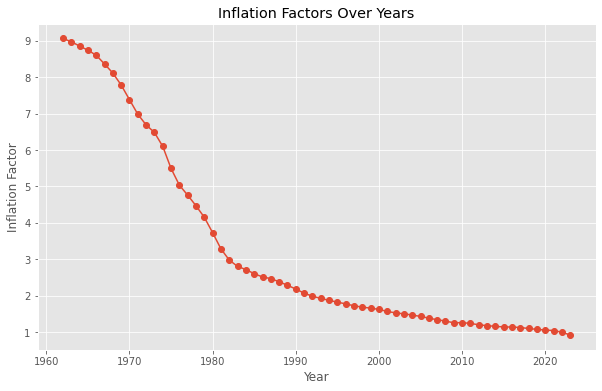

In [11]:
# Extract years (keys) and factors (values)
years = list(inflation_factors.keys())
factors = list(inflation_factors.values())

# Create the line plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(years, factors, marker='o')  # 'o' adds a circle marker at each data point

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Inflation Factor')
plt.title('Inflation Factors Over Years')

# Show the plot
plt.show()

In [12]:
# Map each year to its inflation factor, filling missing years with 1 (no adjustment)
factors_series = data['YEAR'].map(inflation_factors).fillna(1)

# Perform vectorized multiplication
data['INCTOT22'] = data['INCTOT'] * factors_series
data['HHINCOME22'] = data['HHINCOME'] * factors_series

In [13]:
data[['YEAR', 'INCTOT', 'INCTOT22', 'HHINCOME', 'HHINCOME22']]

,YEAR,INCTOT,INCTOT22,HHINCOME,HHINCOME22
0,1962,0.0,0.000000,NaN,NaN
1,1962,NaN,NaN,NaN,NaN
2,1962,NaN,NaN,NaN,NaN
3,1962,1692.0,15329.641824,NaN,NaN
4,1962,1522.0,13789.429584,NaN,NaN
...,...,...,...,...,...
9843809,2023,0.0,0.000000,90415.0,83651.41551
9843810,2023,0.0,0.000000,90415.0,83651.41551
9843811,2023,33113.0,30635.948922,118070.0,109237.65558
9843812,2023,78092.0,72250.249848,118070.0,109237.65558


## Household Income

We will use the [HHINCOME variable](https://cps.ipums.org/cps-action/variables/HHINCOME#description_section):

> HHINCOME reports the total money income during the previous calendar year of all adult household members. The amount should equal the sum of all household members' individual incomes as recorded in the IPUMS-CPS variable INCTOT. The persons included were those present in the household at the time of the survey. People who lived in the household during the previous year but were not still living there at the time of the survey are not included; household members who lived elsewhere during the previous year but had joined the household at the time of the survey are included.

### De-Rectangularization

From the [IPUMS FAQ](https://cps.ipums.org/cps-action/faq#ques21):
> By default, the extract system rectangularizes the data: it puts the household information on the person records and drops the separate household record. This can distort analyses at the household level. The number of observations will be inflated to the number of person records. __You can either select the first person in each household (PERNUM)__ or select the "hierarchical" box in the extract system to get the proper number of household observations. The rectangularizing feature also drops any vacant households, which are otherwise available in some samples. Despite these complications, the great majority of researchers prefer the rectangularized format, which is why it is the default output of our system.

In [14]:
household_data = data.loc[data['PERNUM'] == 1]

### Weighting

From the [IPUMS FAQ](https://cps.ipums.org/cps-action/faq#ques7):

> The IPUMS-CPS samples are weighted, with some records representing more cases than others. This means that persons and households with some characteristics are over-represented in the samples, while others are underrepresented.

> For household-level analyses of the ASEC, weight the households using the ASECWTH variable. ASECWTH gives the number of households in the general population represented by each household in the sample.

In [15]:
household_data

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,HFLAG,ASECWTH,HHINCOME,PERNUM,CPSIDP,CPSIDV,ASECWT,AGE,SEX,FTOTVAL,INCTOT,INCTOT22,HHINCOME22
0,1962,1,3,NaN,NaN,NaN,1494.99,NaN,1,NaN,NaN,1494.99,18,2,NaN,0.0,0.000000,NaN
1,1962,2,3,NaN,NaN,NaN,1568.53,NaN,1,NaN,NaN,1568.53,14,1,NaN,NaN,NaN,NaN
2,1962,3,3,NaN,NaN,NaN,6443.03,NaN,1,NaN,NaN,6443.03,72,1,NaN,NaN,NaN,NaN
3,1962,4,3,NaN,NaN,NaN,1473.97,NaN,1,NaN,NaN,1473.97,29,1,NaN,1692.0,15329.641824,NaN
4,1962,5,3,NaN,NaN,NaN,1538.21,NaN,1,NaN,NaN,1538.21,21,1,NaN,1522.0,13789.429584,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9843794,2023,88974,3,0.0,1.0,NaN,364.45,96000.0,1,0.0,0.0,364.45,52,1,96000.0,45000.0,41633.730000,88818.624000
9843798,2023,88975,3,0.0,1.0,NaN,682.96,173540.0,1,0.0,0.0,682.96,43,2,173540.0,97000.0,89743.818000,160558.166760
9843800,2023,88976,3,0.0,1.0,NaN,445.78,211102.0,1,0.0,0.0,445.78,69,2,211102.0,65809.0,60886.091946,195310.303788
9843806,2023,88977,3,0.0,1.0,NaN,413.20,90415.0,1,0.0,0.0,413.20,51,2,90415.0,50215.0,46458.616710,83651.415510


## Individual income

We will use the [INCTOT variable](https://cps.ipums.org/cps-action/variables/INCTOT#description_section):

> INCTOT indicates each respondent's total pre-tax personal income or losses from all sources for the previous calendar year. Amounts are expressed as they were reported to the interviewer; users must adjust for inflation using Consumer Price Index adjustment factors.

### Weighting

From the [IPUMS FAQ](https://cps.ipums.org/cps-action/faq#ques7)

> The IPUMS-CPS samples are weighted, with some records representing more cases than others. This means that persons and households with some characteristics are over-represented in the samples, while others are underrepresented.

> 1. For most person-level analyses of the ASEC samples, apply the ASECWT variable. ASECWT gives the population represented by each individual in the sample.

### Male and Female Income

We can use the `SEX` variable to plot male and female incomes. `SEX` uses [the following coding](https://cps.ipums.org/cps-action/variables/SEX#codes_section):
- 1 = Male
- 2 = Female
- 9 = NIU (Not in universe)

So all we need to do is filter the based on `SEX` and then plot individual income as above.

In [16]:
male_data = data.loc[data['SEX'] == 1]
female_data = data.loc[data['SEX'] == 2]

In [17]:
import json

# Define some data to write to JSON
data = {
  "title": "Sample Distribution Data",
  "binsX": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  "labels": ["$0k", "$100k", "$200k", "$300k", "$400k", "$500k", "$600k", "$700k", "$800k", "$900k", "$1M"],
  "labelsX": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  "years": [1973, 2023],
  "values": {
    "1973": [5, 10, 15, 20, 25, 30, 25, 20, 15, 10, 5],
    "2023": [3, 6, 9, 12, 15, 18, 15, 12, 9, 6, 3]
  },
  "yLimits": [0, 30]
}


# Specify the filename
filename = 'webpage/data.json'

# Writing JSON data
with open(filename, 'w') as f:
    json.dump(data, f, indent=4)

# Generate JSON

In [29]:
def linear_distplot_to_json(
        data, 
        income_col, 
        year_col, 
        weights_col=None,
        max_income=None, 
        min_income=None, 
        years=None,
        x_lim=None,
        title='',
        save_as="data.json"  # Default filename if not provided
    ):
    if years is not None:
        data = data[data[year_col].isin(years)]
        
    data_filtered = data[data[income_col].notna()].copy()

    if max_income is not None:
        data_filtered[income_col] = np.minimum(data_filtered[income_col], max_income)
    if min_income is not None:
        data_filtered[income_col] = np.maximum(data_filtered[income_col], min_income)

    grouped_data = data_filtered.groupby(year_col)

    bin_edges = list(range(0, 200000 + 1, 5000)) + [np.inf]
    overall_bins = pd.cut(data_filtered[income_col], bins=bin_edges, retbins=True)[1]

    values_dict = {}
    max_percentage = 0
    for year, group in grouped_data:
        incomes = group[income_col]
        weights = group[weights_col] if weights_col else None

        counts, _ = np.histogram(incomes, bins=overall_bins, weights=weights)
        percentages = (counts / counts.sum()) * 100 if counts.sum() > 0 else np.zeros_like(counts)
        values_dict[int(year)] = percentages.tolist()

        max_percentage = max(max_percentage, percentages.max())
        
    y_upper_lim = max_percentage * 1.1

    json_data = {
        "binsX": bin_edges[:-1],
        "labelsX": [0, 50000, 100000, 150000, 200000],
        "labels": ['$0k', '$50k', '$100k', '$150k', '$200k+'],
        "years": sorted(values_dict.keys()),
        "values": values_dict,
        "title": title,
        "yLimits": [0, y_upper_lim]
    }
    
    # Save the generated JSON data to a file
    with open(save_as, 'w') as f:
        json.dump(json_data, f, indent=4)
    
    return json_data

# Adjust the parameters below as per your data and requirements
json_data = linear_distplot_to_json(
    household_data,
    'HHINCOME22',
    'YEAR',
    max_income=200000,
    min_income=0,
    x_lim=(0, 200000),
    years=range(1973,2024,10),
    title="Household Income in 2022 dollars (% of households)", 
    weights_col='ASECWTH',
    save_as='./webpage/data.json'
)

In [ ]:
import numpy as np
import pandas as pd
import json

def linear_distplot_to_json(
        data, 
        income_col, 
        year_col, 
        weights_col=None,
        max_income=None, 
        min_income=None, 
        years=None,
        x_lim=None,
        title='',
        bin_edges=None,  # New parameter for custom bin edges
        transform_func=None,  # New parameter for an optional transformation function
        save_as="data.json"  # Default filename if not provided
    ):
    if years is not None:
        data = data[data[year_col].isin(years)]
        
    data_filtered = data[data[income_col].notna()].copy()

    # Apply optional transformation function if specified
    if transform_func is not None:
        data_filtered[income_col] = data_filtered[income_col].apply(transform_func)

    if max_income is not None:
        data_filtered[income_col] = np.minimum(data_filtered[income_col], max_income)
    if min_income is not None:
        data_filtered[income_col] = np.maximum(data_filtered[income_col], min_income)

    # Use custom bin edges if provided, else default to specified range
    if bin_edges is None:
        bin_edges = list(range(0, 200000 + 1, 5000)) + [np.inf]
    overall_bins = pd.cut(data_filtered[income_col], bins=bin_edges, retbins=True)[1]

    values_dict = {}
    max_percentage = 0
    for year, group in grouped_data:
        incomes = group[income_col]
        weights = group[weights_col] if weights_col else None

        counts, _ = np.histogram(incomes, bins=overall_bins, weights=weights)
        percentages = (counts / counts.sum()) * 100 if counts.sum() > 0 else np.zeros_like(counts)
        values_dict[int(year)] = percentages.tolist()

        max_percentage = max(max_percentage, percentages.max())
        
    y_upper_lim = max_percentage * 1.1

    json_data = {
        "binsX": bin_edges[:-1],
        "labelsX": [0, 50000, 100000, 150000, 200000],  # Customize based on your bin_edges if needed
        "labels": ['$0k', '$50k', '$100k', '$150k', '$200k+'],  # Customize these labels to match the bin_edges
        "years": sorted(values_dict.keys()),
        "values": values_dict,
        "title": title,
        "yLimits": [0, y_upper_lim]
    }
    
    # Save the generated JSON data to a file
    with open(save_as, 'w') as f:
        json.dump(json_data, f, indent=4)
    
    return json_data


In [61]:
import numpy as np
import pandas as pd
import json

def linear_distplot_to_json(
        data, 
        income_col, 
        year_col, 
        weights_col=None,
        max_income=None, 
        min_income=None, 
        years=None,
        x_lim=None,
        title='',
        bin_edges=None,  # Custom bin edges
        transform_func=None,  # Optional transformation function for income values
        labels=None,  # Custom labels for x-axis
        labelsX=None,  # Custom x positions for labels
        save_as="data.json"  # Default filename if not provided
    ):
    
    # filter data
    if years is not None:
        data = data[data[year_col].isin(years)]
    data_filtered = data[data[income_col].notna()].copy()

    if max_income is not None:
        data_filtered[income_col] = np.minimum(data_filtered[income_col], max_income)
    if min_income is not None:
        data_filtered[income_col] = np.maximum(data_filtered[income_col], min_income)

    grouped_data = data_filtered.groupby(year_col)

    values_dict = {}
    max_percentage = 0
    for year, group in grouped_data:
        counts, _ = np.histogram(
            group[income_col],
            bins=bin_edges,
            weights=group[weights_col]
        )
        percentages = (counts / counts.sum()) * 100 if counts.sum() > 0 else np.zeros_like(counts)
        values_dict[int(year)] = percentages.tolist()

        max_percentage = max(max_percentage, percentages.max())
        
    y_upper_lim = max_percentage * 1.1

    return {
        "binsX": bin_edges[:-1],
        "years": sorted(values_dict.keys()),
        "values": values_dict,
        "title": title,
        "yLimits": [0, y_upper_lim]
    }

years = range(1973, 2024, 5)

# Example call to the function with the new arguments
json_data = linear_distplot_to_json(
    data=household_data,
    income_col='HHINCOME22',
    year_col='YEAR',
    weights_col='ASECWTH',
    # max_income=200000,
    min_income=0,
    years=years,
    title="Household Income in 2022 dollars (% of households)",
    bin_edges=list(range(0, int(1.5e6 + 1), 5000)) + [np.inf]
)

from math import log

def x_axis_stretch(x):
    # this smoothly transitions a linear plot into a log plot
    # see what this looks like here: https://www.desmos.com/calculator/u6ovmmekxv
    
    # become log at:
    a = 200e3
    # the scale of the logarithm:
    k = 25e3
    
    return x if x<a else a + k*log((x-a)/k+1)

# Example custom labels and positions
json_data['labels'] = ['$0k', '$50k', '$100k', '$150k', '$200k', '$250k', '$500k', '$1M']
json_data['labelsX'] = [0, 50e3, 100e3, 150e3, 200e3, 250e3, 500e3, 1e6]

json_data['timePerYear'] = [1] * (len(years)-1)+[5]

#json_data['labels'] = ['$0k', '$50k', '$100k', '$150k', '$200k', '$250k', '$1M']
#json_data['labelsX'] = [0, 50e3, 100e3, 150e3, 200e3, 250e3, 1e6]

json_data['binsX'] = [ x_axis_stretch(x) for x in json_data['binsX'] ]
json_data['labelsX'] = [ x_axis_stretch(x) for x in json_data['labelsX'] ]
json_data['yLimits'] = [0, 8]

with open('./webpage/data.json', 'w') as f:
    json.dump(json_data, f, indent=4)

In [41]:


math.log(10)

2.302585092994046

# Linear Distribution Plots

In [72]:
def linear_distplot(
        data, 
        income_col, 
        year_col, 
        weights_col=None,
        max_income=None, 
        min_income=None, 
        x_lim=None, 
        title="Income", 
        xlabel="Income (USD)", 
        ylabel="%", 
        save_as="income_animation.gif",
        figsize=(10, 6)
    ):
    """
    Creates and saves an animated linear histogram/distribution plot of incomes over time.
    You can truncate the income values at either end with max_income and min_income.
    You can specify the boundaries of the plot with x_lim=(0, 100000) for example.

    Parameters:
        data (pandas.DataFrame): The DataFrame containing the data.
        income_col (str): The name of the column representing income values.
        year_col (str): The name of the column representing year values.
        weights_col (str, optional): The name of the column representing row weights. Default is None.
        truncate (float, optional): A value to truncate the income values. Default is None.
        x_lim (tuple, optional): The limits for the x-axis as a tuple (min, max). Default is None.
        title (str, optional): The title of the plot. Default is "Household income".
        xlabel (str, optional): The label for the x-axis. Default is "Household income (USD)".
        ylabel (str, optional): The label for the y-axis. Default is "% of households".
        save_as (str, optional): The filename to save the animation. Default is "income_animation.gif".
    """
    data_filtered = data[data[income_col].notna()].copy()

    if max_income is not None:
        data_filtered[income_col] = np.minimum(data_filtered[income_col], max_income)
    if min_income is not None:
        data_filtered[income_col] = np.maximum(data_filtered[income_col], min_income)

    grouped_data = data_filtered.groupby(year_col)
    bin_edges = list(range(0, 200000 + 1, 5000)) + [np.inf]
    overall_bins = pd.cut(data_filtered[income_col], bins=bin_edges, retbins=True)[1]
    
    # Store percentage data for each year
    percentages_dict = {}
    max_percentage = 0
    for year, group in grouped_data:
        incomes = group[income_col]
        weights = group[weights_col] if weights_col else None

        counts, bins = np.histogram(incomes, bins=overall_bins, weights=weights)
        total = counts.sum()
        percentages = (counts / total) * 100 if total > 0 else np.zeros_like(counts)
        percentages_dict[year] = (percentages, bins)

        # Update max percentage for y-axis limit
        max_percentage = max(max_percentage, np.max(percentages))

    y_upper_lim = max_percentage * 1.1

    fig, ax = plt.subplots(figsize=figsize)

    def animate(year):
        ax.clear()
        percentages, bins = percentages_dict[year]

        widths = np.diff(bins)
        ax.bar(bins[:-1], percentages, width=widths, color='blue', alpha=0.7)

        ax.set_title(f'{title} in {year}')
        
        # Set custom tick labels
        ax.set_xticks([0, 50000, 100000, 150000, 200000])
        ax.set_xticklabels(['$0k', '$50k', '$100k', '$150k', '$200k+'])
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0, y_upper_lim)
        if x_lim is not None:
            ax.set_xlim(x_lim)

    years = data_filtered[year_col].unique()

    ani = animation.FuncAnimation(fig, animate, frames=years, repeat=False)
    ani.save(save_as)
    # to supress the last frame from being displayed in the notebook
    plt.close()

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def linear_distplot(
        data, 
        income_col, 
        year_col, 
        weights_col=None,
        max_income=None,
        min_income=None,
        title="Income", 
        xlabel="Income (USD)", 
        ylabel="%", 
        save_as="income_animation.gif",
        figsize=(10, 6)
    ):
    """
    ... [existing docstring] ...
    """
    data_filtered = data[data[income_col].notna()].copy()

    # Ensure values are within the specified range, if provided
    if max_income is not None:
        data_filtered[income_col] = np.minimum(data_filtered[income_col], max_income)
    if min_income is not None:
        data_filtered[income_col] = np.maximum(data_filtered[income_col], min_income)

    # Group data by year
    grouped_data = data_filtered.groupby(year_col)

    # Define bin edges in increments of $5k up to $200k, then add a bin for $200k+
    bin_edges = list(range(0, 200000 + 1, 5000)) + [np.inf]
    overall_bins = pd.cut(data_filtered[income_col], bins=bin_edges, retbins=True)[1]

    # Store percentage data for each year
    percentages_dict = {}
    max_percentage = 0
    for year, group in grouped_data:
        incomes = group[income_col]
        weights = group[weights_col] if weights_col else None

        counts, bins = np.histogram(incomes, bins=overall_bins, weights=weights)
        total = counts.sum()
        percentages = (counts / total) * 100 if total > 0 else np.zeros_like(counts)
        percentages_dict[year] = (percentages, bins)

        # Update max percentage for y-axis limit
        max_percentage = max(max_percentage, np.max(percentages))

    y_upper_lim = max_percentage * 1.1

    fig, ax = plt.subplots(figsize=figsize)

    def animate(year):
        ax.clear()
        percentages, bins = percentages_dict[year]

        # Adjust bar width and alignment
        widths = np.diff(bins)
        ax.bar(bins[:-1], percentages, width=widths, align='edge', color='blue', alpha=0.7)

        ax.set_title(f'{title} in {year}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0, y_upper_lim)

        # Set custom tick labels for every $20k increment, plus one for $200k+
        tick_labels = [f"${x}k" for x in range(0, 200, 20)] + ['>$200k']
        ax.set_xticks(range(0, 200000, 20000) + [200000])
        ax.set_xticklabels(tick_labels)

    years = data_filtered[year_col].unique()

    ani = animation.FuncAnimation(fig, animate, frames=years, repeat=False)
    ani.save(save_as)
    plt.close()

# Example usage
# linear_distplot(your_dataframe, 'income_col_name', 'year_col_name', ...)


/Users/hamish/miniconda3/lib/python3.8/site-packages/matplotlib/patches.py:750: RuntimeWarning: invalid value encountered in scalar add
  self._x1 = self._x0 + self._width
/Users/hamish/miniconda3/lib/python3.8/site-packages/matplotlib/transforms.py:1977: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx


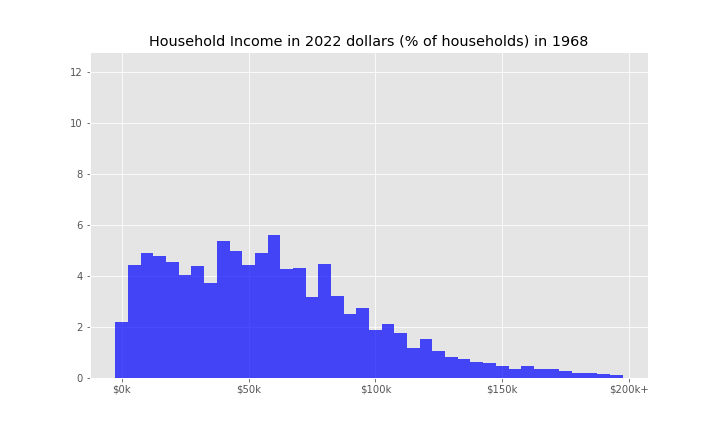

In [73]:
fname = 'animations/household_income_linear.gif'
linear_distplot(
    household_data,
    'HHINCOME22',
    'YEAR',
    title="Household Income in 2022 dollars (% of households)", 
    xlabel="",
    ylabel="",
    weights_col='ASECWTH',
    save_as=fname,
    figsize=(10, 6)
)
Image(filename=fname)

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def linear_distplot(
        data, 
        income_col, 
        year_col, 
        weights_col=None,
        max_income=None, 
        min_income=None, 
        years=None,
        x_lim=None, 
        title="Income", 
        xlabel="Income (USD)", 
        ylabel="%", 
        save_as="income_animation.gif",
        figsize=(10, 6)
    ):
    """
    ... [existing docstring] ...
    """
    
    if years is not None:
        data = data[data[year_col].isin(years)]
        
    data_filtered = data[data[income_col].notna()].copy()

    # Apply truncation if specified
    if max_income is not None:
        data_filtered[income_col] = np.minimum(data_filtered[income_col], max_income)
    if min_income is not None:
        data_filtered[income_col] = np.maximum(data_filtered[income_col], min_income)

    # Group data by year
    grouped_data = data_filtered.groupby(year_col)

    # Define bin edges in increments of $5k up to $200k, then add a bin for $200k+
    bin_edges = list(range(0, 200000 + 1, 5000)) + [np.inf]
    overall_bins = pd.cut(data_filtered[income_col], bins=bin_edges, retbins=True)[1]
    print(bin_edges)
    print(overall_bins)

    # Store percentage data for each year
    percentages_dict = {}
    max_percentage = 0
    for year, group in grouped_data:
        incomes = group[income_col]
        weights = group[weights_col] if weights_col else None

        counts, bins = np.histogram(incomes, bins=overall_bins, weights=weights)
        total = counts.sum()
        percentages = (counts / total) * 100 if total > 0 else np.zeros_like(counts)
        percentages_dict[year] = (percentages, bins)

        # Update max percentage for y-axis limit
        max_percentage = max(max_percentage, np.max(percentages))

    y_upper_lim = max_percentage * 1.1

    fig, ax = plt.subplots(figsize=figsize)

    def animate(year):
        ax.clear()
        percentages, bins = percentages_dict[year]

        # Adjust bar width and alignment
        widths = np.diff(bins)
        ax.bar(bins[:-1], percentages, width=widths, align='edge', color='blue', alpha=0.7)

        ax.set_title(f'{title} in {year}')

        # Set custom tick labels for every $5k increment, plus one for $200k+
        #tick_labels = [f"${x}k" for x in range(0, 205, 5)]
        #ax.set_xticks(list(range(0, 200000, 5000)) + [200000])
        #ax.set_xticklabels(tick_labels, rotation=90)  # Rotate for better readability
        
        # Set custom tick labels
        ax.set_xticks([0, 50000, 100000, 150000, 200000])
        ax.set_xticklabels(['$0k', '$50k', '$100k', '$150k', '$200k+'])

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0, y_upper_lim)
        if x_lim is not None:
            ax.set_xlim(x_lim)

    years = data_filtered[year_col].unique()

    ani = animation.FuncAnimation(fig, animate, frames=years, repeat=False)
    ani.save(save_as)
    plt.close()

[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, inf]
[     0.   5000.  10000.  15000.  20000.  25000.  30000.  35000.  40000.
  45000.  50000.  55000.  60000.  65000.  70000.  75000.  80000.  85000.
  90000.  95000. 100000. 105000. 110000. 115000. 120000. 125000. 130000.
 135000. 140000. 145000. 150000. 155000. 160000. 165000. 170000. 175000.
 180000. 185000. 190000. 195000. 200000.     inf]


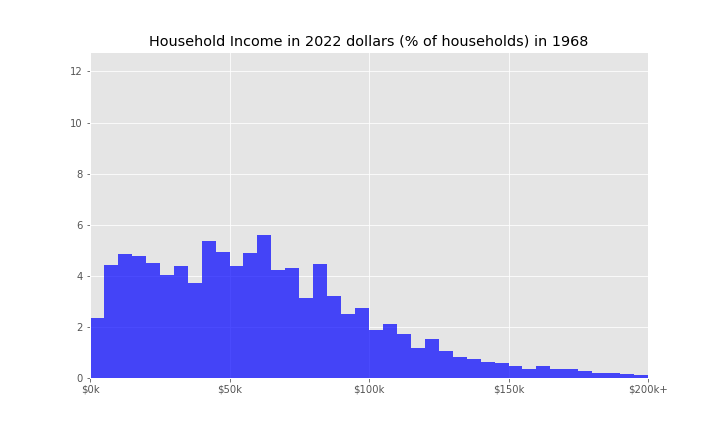

In [94]:
fname = 'animations/household_income.gif'
linear_distplot(
    household_data,
    'HHINCOME22',
    'YEAR',
    max_income=200000,
    min_income=0,
    x_lim=(0, 200000),
    title="Household Income in 2022 dollars (% of households)", 
    xlabel="",
    ylabel="",
    weights_col='ASECWTH',
    save_as=fname,
    figsize=(10, 6)
)
Image(filename=fname)

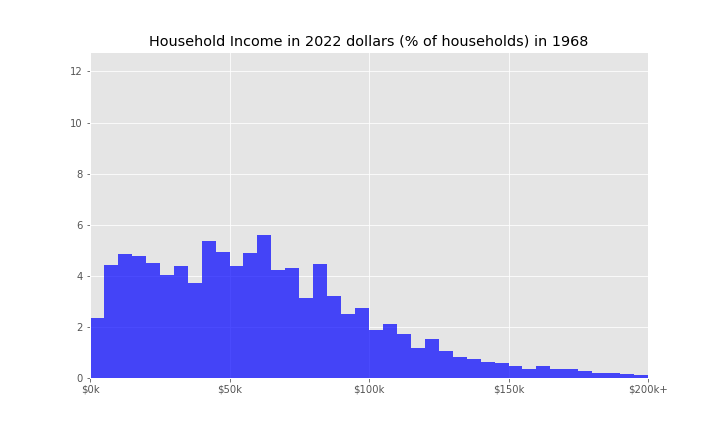

In [92]:
fname = 'animations/household_income.gif'
linear_distplot(
    household_data,
    'HHINCOME22',
    'YEAR',
    max_income=200000,
    min_income=0,
    x_lim=(0, 200000),
    title="Household Income in 2022 dollars (% of households)", 
    xlabel="",
    ylabel="",
    weights_col='ASECWTH',
    save_as=fname,
    figsize=(10, 6)
)
Image(filename=fname)

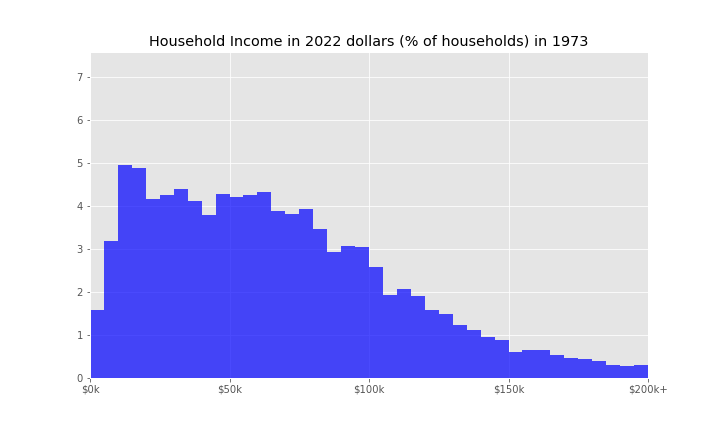

In [83]:
fname = 'animations/household_income_decades.gif'
linear_distplot(
    household_data,
    'HHINCOME22',
    'YEAR',
    max_income=200000,
    min_income=0,
    x_lim=(0, 200000),
    years=range(1973,2024,10),
    title="Household Income in 2022 dollars (% of households)", 
    xlabel="",
    ylabel="",
    weights_col='ASECWTH',
    save_as=fname,
    figsize=(10, 6)
)
Image(filename=fname)

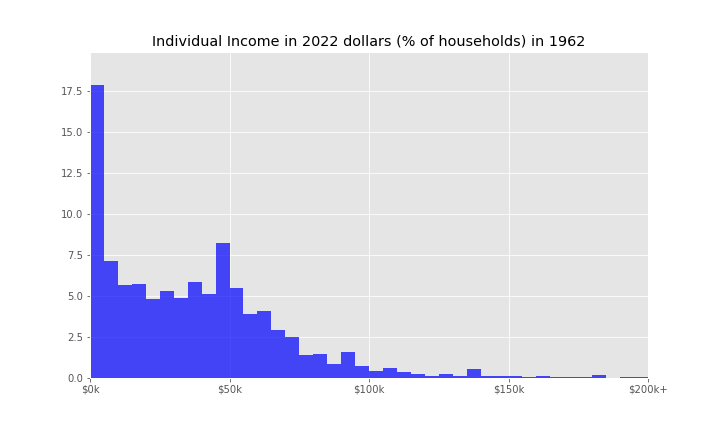

In [89]:
fname = 'animations/individual_income.gif'
linear_distplot(
    male_data,
    'INCTOT22', 
    'YEAR', 
    max_income=300000,
    min_income=0,
    x_lim=(0, 200000), 
    title="Individual Income in 2022 dollars (% of households)", 
    xlabel="", 
    ylabel="", 
    weights_col='ASECWT',
    save_as=fname
)
Image(filename=fname)

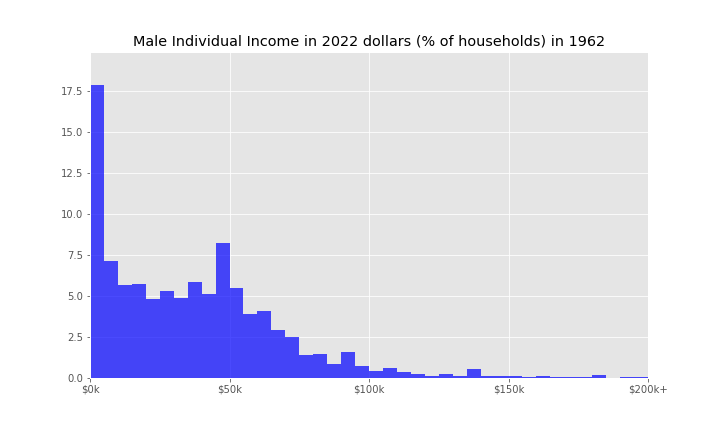

In [90]:
fname = 'animations/male_income.gif'
linear_distplot(
    male_data,
    'INCTOT22', 
    'YEAR', 
    max_income=300000,
    min_income=0,
    x_lim=(0, 200000), 
    title="Male Individual Income in 2022 dollars (% of households)", 
    xlabel="", 
    ylabel="", 
    weights_col='ASECWT',
    save_as=fname
)
Image(filename=fname)

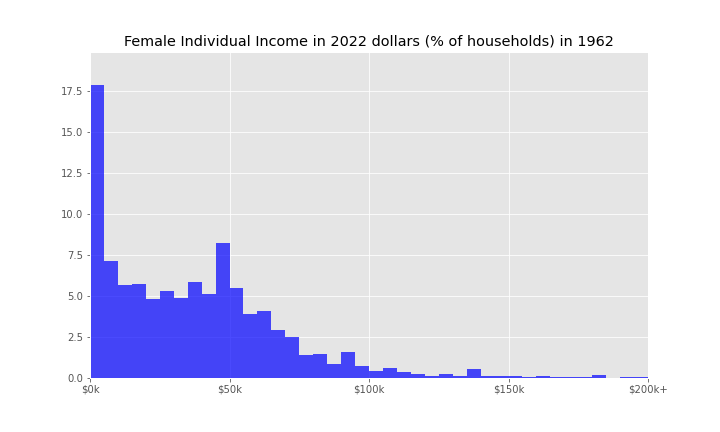

In [91]:
fname = 'animations/female_income.gif'
linear_distplot(
    male_data,
    'INCTOT22', 
    'YEAR', 
    max_income=300000,
    min_income=0,
    x_lim=(0, 200000), 
    title="Female Individual Income in 2022 dollars (% of households)", 
    xlabel="", 
    ylabel="", 
    weights_col='ASECWT',
    save_as=fname
)
Image(filename=fname)

# Custom Bins

In [33]:
def format_bin_labels(bin_edges):
    """
    convert this: [-np.inf, 0, 50000, 100000, np.inf])
    into this: ['<$0', '$0-50k', '$50-100k', '>$100k']
    """
    return [
        f"<${int(end)//1000}k" if start == -np.inf else 
        f">${int(start)//1000}k" if end == np.inf else 
        f"\${int(start)//1000}-\${int(end)//1000}k"
        for start, end in zip(bin_edges[:-1], bin_edges[1:])
    ]

def custom_bins(
        data, 
        income_col, 
        year_col, 
        bin_edges,
        title="Income", 
        xlabel="Income (USD)", 
        ylabel="%", 
        save_as="income_animation.gif",
        weights_col=None,
        figsize=(10, 6)
    ):
    """
    ... [existing docstring] ...
    """
    data_filtered = data[data[income_col].notna()].copy()

    grouped_data = data_filtered.groupby(year_col)

    bin_labels = format_bin_labels(bin_edges)
    
    # Store percentage data for each year
    percentages_dict = {}
    max_percentage = 0
    for year, group in grouped_data:
        # Compute bins for each group/year
        group['bin'] = pd.cut(group[income_col], bins=bin_edges, labels=bin_labels, include_lowest=True)
        
        # Group by the custom bins and calculate weights or counts
        grouped = group.groupby('bin')
        counts = grouped[weights_col].sum() if weights_col else grouped.size()
        total = counts.sum()
        percentages = (counts / total) * 100 if total > 0 else pd.Series(np.zeros_like(bin_labels), index=bin_labels)
        percentages_dict[year] = percentages

        # Update max percentage for y-axis limit
        max_percentage = max(max_percentage, percentages.max())

    y_upper_lim = max_percentage * 1.1

    fig, ax = plt.subplots(figsize=figsize)

    def animate(year):
        ax.clear()
        percentages = percentages_dict[year]

        # Plotting each bin as a bar
        ax.bar(bin_labels, percentages, color='blue', alpha=0.7)

        ax.set_title(f'{title} in {year}')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0, y_upper_lim)

    years = data_filtered[year_col].unique()

    ani = animation.FuncAnimation(fig, animate, frames=years, repeat=False)
    ani.save(save_as)
    plt.close()


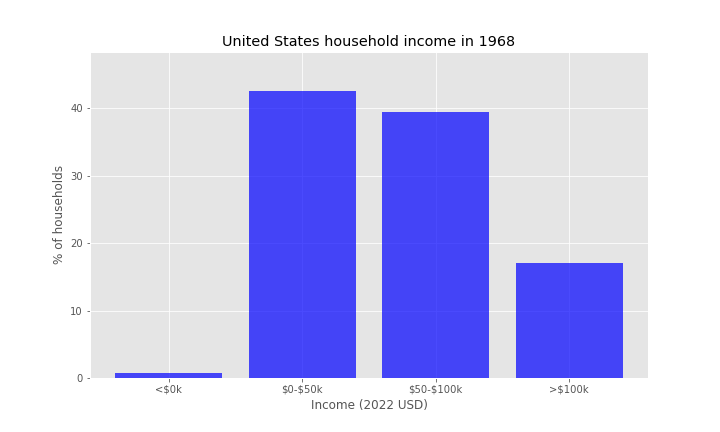

In [26]:
fname = 'animations/household_income_4_bins.gif'
custom_bins(
    household_data,
    income_col = 'HHINCOME22', 
    year_col = 'YEAR', 
    bin_edges = [-np.inf, 0, 50000, 100000, np.inf],
    title="United States household income", 
    xlabel="Income (2022 USD)", 
    ylabel="% of households", 
    weights_col='ASECWTH',
    save_as=fname
)
Image(filename=fname)

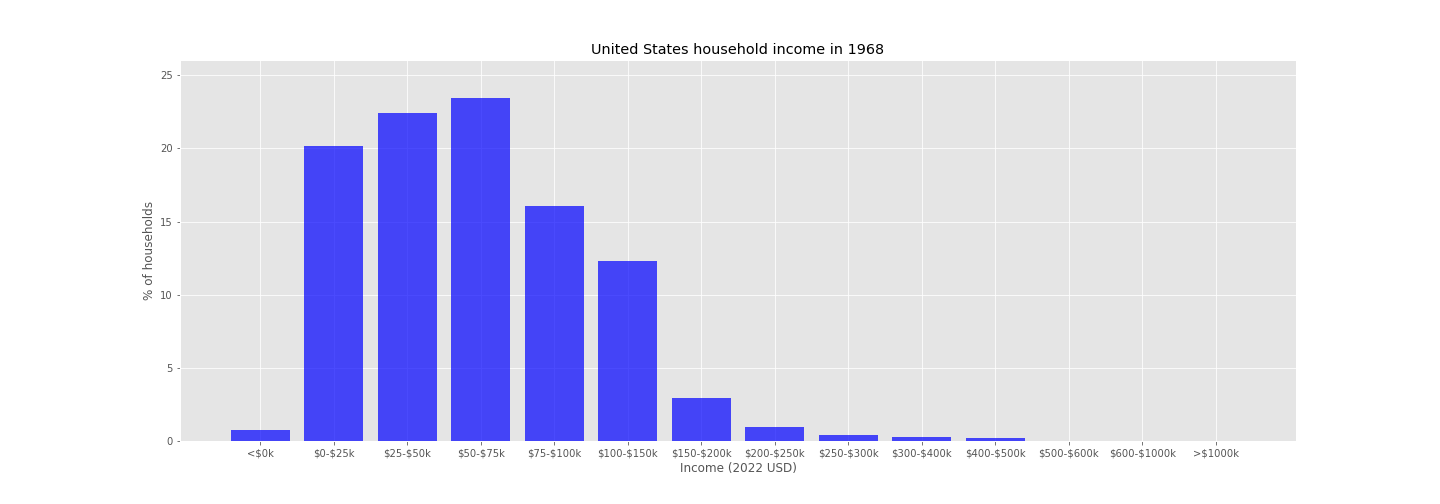

In [27]:
fname = 'animations/household_income_wide.gif'
custom_bins(
    household_data,
    income_col = 'HHINCOME22', 
    year_col = 'YEAR', 
    bin_edges = [-np.inf, 0, 25000, 50000, 75000, 100000, 150000, 200000, 250000, 300000, 400000, 500000, 600000, 1e6, np.inf],
    title="United States household income", 
    xlabel="Income (2022 USD)", 
    ylabel="% of households", 
    weights_col='ASECWTH',
    figsize=(20, 7),
    save_as=fname
)
Image(filename=fname)

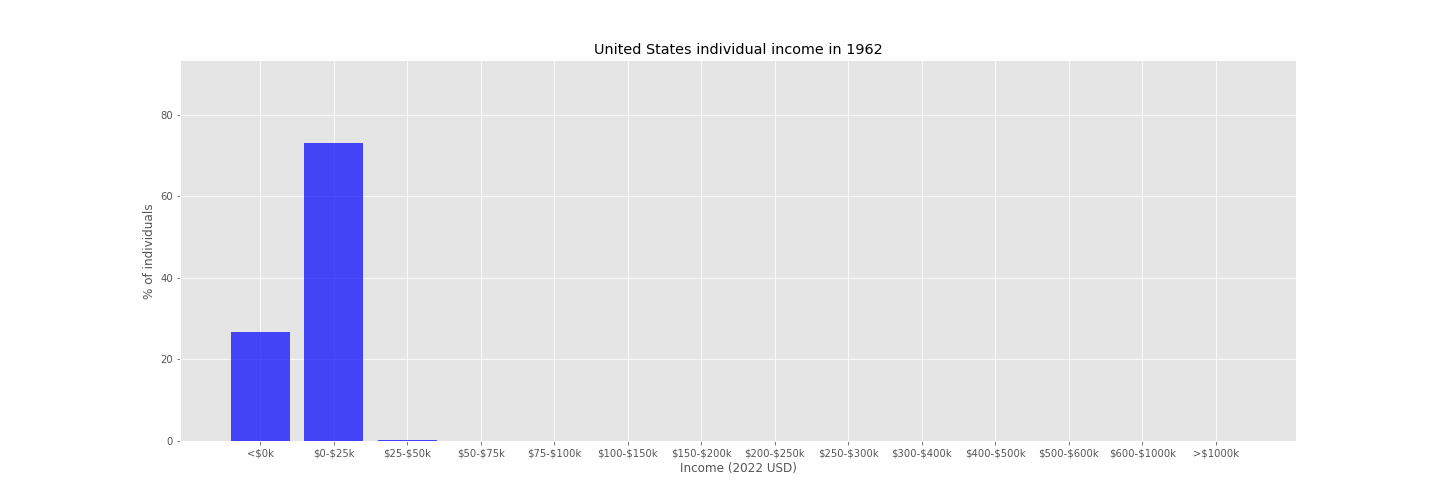

In [29]:
fname = 'animations/individual_income_wide.gif'
custom_bins(
    data,
    income_col = 'INCTOT', 
    year_col = 'YEAR', 
    bin_edges = [-np.inf, 0, 25000, 50000, 75000, 100000, 150000, 200000, 250000, 300000, 400000, 500000, 600000, 1e6, np.inf],
    title="United States individual income", 
    xlabel="Income (2022 USD)", 
    ylabel="% of individuals", 
    weights_col='ASECWT',
    figsize=(20, 7),
    save_as=fname
)
Image(filename=fname)

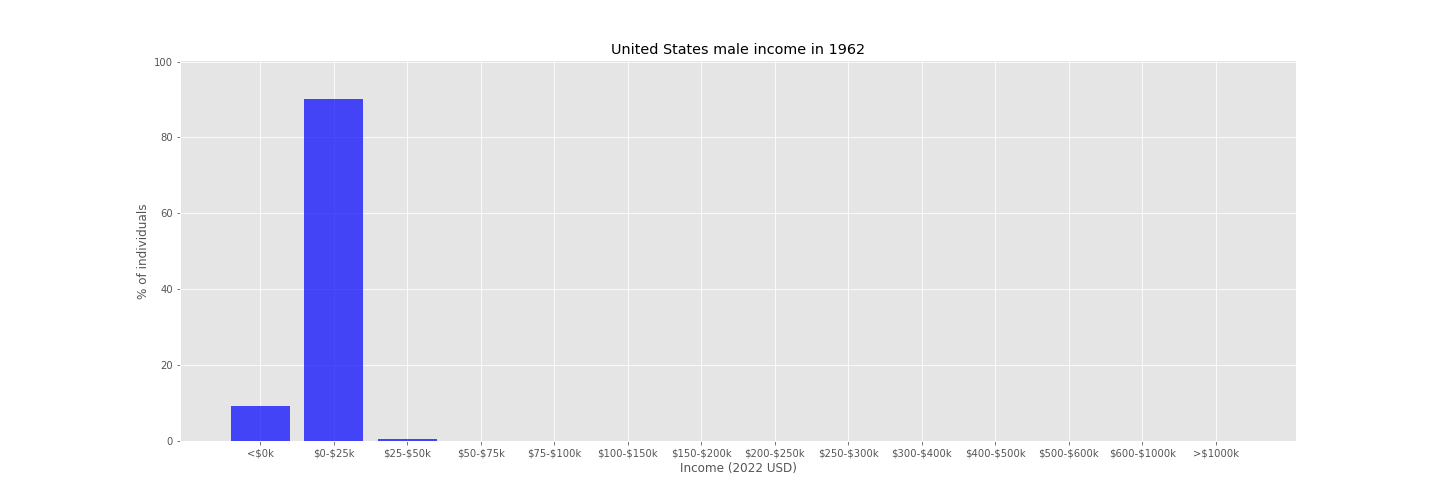

In [31]:
fname = 'animations/male_income_wide.gif'
custom_bins(
    male_data,
    income_col = 'INCTOT', 
    year_col = 'YEAR', 
    bin_edges = [-np.inf, 0, 25000, 50000, 75000, 100000, 150000, 200000, 250000, 300000, 400000, 500000, 600000, 1e6, np.inf],
    title="United States male income", 
    xlabel="Income (2022 USD)", 
    ylabel="% of individuals", 
    weights_col='ASECWT',
    figsize=(20, 7),
    save_as=fname
)
Image(filename=fname)

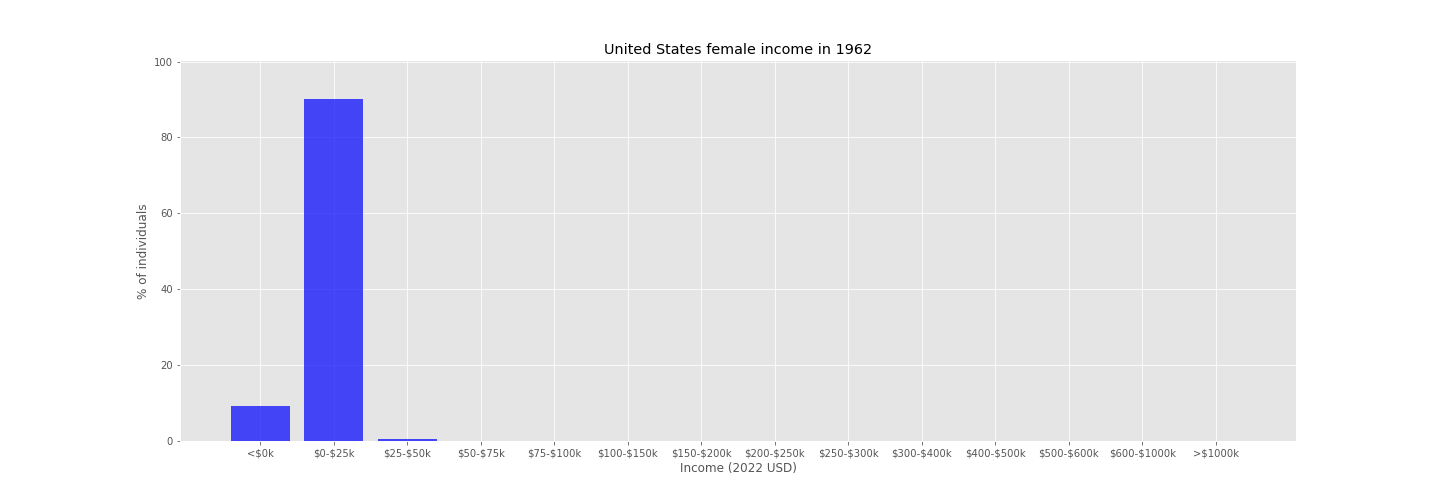

In [34]:
fname = 'animations/female_income_wide.gif'
custom_bins(
    male_data,
    income_col = 'INCTOT',
    year_col = 'YEAR',
    bin_edges = [-np.inf, 0, 25000, 50000, 75000, 100000, 150000, 200000, 250000, 300000, 400000, 500000, 600000, 1e6, np.inf],
    title="United States female income",
    xlabel="Income (2022 USD)",
    ylabel="% of individuals",
    weights_col='ASECWT',
    figsize=(20, 7),
    save_as=fname
)
Image(filename=fname)